# Pytorh 实例
因为本实例采用不同的环境，因此分列 

1. `Dataset` 自定义 , (实现在 `AsData.py` 中，需要在这里import）
2. 全连接神经网络 `Net()` 类 (继承自 `nn.Module`)
3. 网络训练和测试
4. 使用 `argparse` 提供自定义参数设计并提供保存模型端口

* 采用 `Dataset` 类 , 规范化的 epoch-batch 数据处理

You are using mps!
Train Epoch: 1 [0/1554 (0%)]	 Total Loss: 4019.420898
Train Epoch: 1 [160/1554 (10%)]	 Total Loss: 405.801178
Train Epoch: 1 [320/1554 (20%)]	 Total Loss: 1021.465210
Train Epoch: 1 [480/1554 (31%)]	 Total Loss: 1818.807373
Train Epoch: 1 [640/1554 (41%)]	 Total Loss: 1557.671753
Train Epoch: 1 [800/1554 (51%)]	 Total Loss: 504.166534
Train Epoch: 1 [960/1554 (61%)]	 Total Loss: 864.955688
Train Epoch: 1 [1120/1554 (71%)]	 Total Loss: 1038.923340
Train Epoch: 1 [1280/1554 (82%)]	 Total Loss: 1475.345581
Train Epoch: 1 [1440/1554 (92%)]	 Total Loss: 568.062134

Test set: Average loss: 6.2459

Train Epoch: 2 [0/1554 (0%)]	 Total Loss: 407.871307
Train Epoch: 2 [160/1554 (10%)]	 Total Loss: 473.562439
Train Epoch: 2 [320/1554 (20%)]	 Total Loss: 310.933075
Train Epoch: 2 [480/1554 (31%)]	 Total Loss: 574.881592
Train Epoch: 2 [640/1554 (41%)]	 Total Loss: 231.965652
Train Epoch: 2 [800/1554 (51%)]	 Total Loss: 361.289124
Train Epoch: 2 [960/1554 (61%)]	 Total Loss: 125.

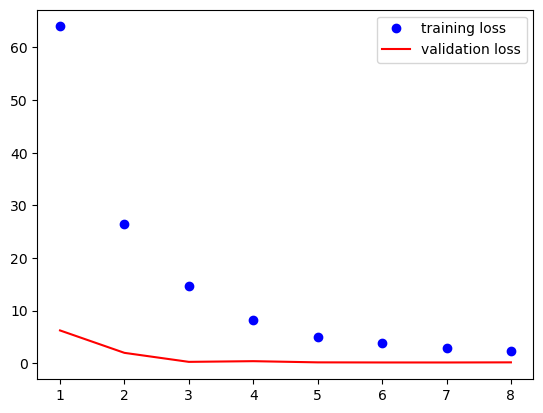

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
import argparse
import numpy as np
import pandas as pd
import time
import warnings
from AsData import AsData
import pdb

# 全局变量
PATH = "./2022期末数据/NMDS_coordinates.csv"
X_NAME = ['mean_rug', 'sd_rug', 'se_rug', 'DIST', 'X_dist',
          'date_diff', 'days', 'Vel', 'X_Vel', 'MidPt']
Y_NAME = ['NMDS1']

output = {}
train_losses = []
val_losses = []

# 网络结构
class Net(nn.Module):
    def __init__(self):  
        super().__init__()
        self.fc1 = nn.Linear(10, 50)
        self.fc2 = nn.Linear(50,1)
    
    def forward(self, x):
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p =0.1, training=self.training)
        x = self.fc2(x)
        #print(x.shape)
        return x

def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # print(data.shape,target.shape)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad() # clean the grad
        output = model(data)
        # print(output,output.shape)
        #pdb.set_trace()
        loss = F.mse_loss(output, target, reduction='sum')

        loss.backward()
        optimizer.step() # update params
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\t Total Loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break
        train_loss += loss.item()
    train_losses.append(train_loss / len(train_loader.dataset))  # epoch train loss
    return

def test(model, device, test_loader):
    model.eval() # 设定dropout状态
    test_loss = 0
    with torch.no_grad(): # 不必在验证集上进行求导
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.mse_loss(output, target, reduction='sum').item()  # sum up batch loss

    test_loss /= len(test_loader.dataset) # 在测试集上按样本数取平均

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))  # epoch test loss
    return test_loss

def main():
    # Training settings
    parser = argparse.ArgumentParser(description='Example for Pytorch')
    parser.add_argument('--batch-size', type=int, default=16, metavar='N',help='input batch size for training (default: 16)')
    parser.add_argument('--test-batch-size', type=int, default=16, metavar='N',help='input batch size for testing (default: 16)')
    parser.add_argument('--epochs', type=int, default=8, metavar='N',help='number of epochs to train (default: 8)')
    parser.add_argument('--lr', type=float, default= 0.5, metavar='LR',help='learning rate (default: 0.5)')
    parser.add_argument('--gamma', type=float, default=0.7, metavar='M',help='Learning rate step gamma (default: 0.7)')
    parser.add_argument('--no-cuda', action='store_true', default=False,help='disables CUDA training')
    parser.add_argument('--dry-run', action='store_true', default=False,help='quickly check a single pass')
    parser.add_argument('--seed', type=int, default=1, metavar='S',help='random seed (default: 1)')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',help='how many batches to wait before logging training status')
    parser.add_argument('--save-model', action='store_true', default=False,help='For Saving the current Model')
    args,unkown = parser.parse_known_args()
    use_cuda = torch.backends.mps.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("mps" if use_cuda else "cpu")
    print(f"You are using {device}!")
    #device = torch.device("cpu")

    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    
    file = pd.read_csv(PATH)
    file = file[['NMDS1','mean_rug', 'sd_rug', 'se_rug', 'DIST', 'X_dist',
                'date_diff', 'days', 'Vel', 'X_Vel', 'MidPt']]

    r = int(file.shape[0]*0.8)

    index = np.random.permutation(file[X_NAME].shape[0]) # 利用index随机打乱数据
    index1 = index[:r]
    index2 = index[r:]
    X_train = np.array(file[X_NAME].iloc[index1])
    y_train = np.array(file[Y_NAME].iloc[index1]).ravel()
    X_test = np.array(file[X_NAME].iloc[index2])
    y_test = np.array(file[Y_NAME].iloc[index2]).ravel()
    del file # 释放内存

    transformation = transforms.Compose([transforms.GaussianBlur(5)])

    train_dataset = AsData(X_train,y_train,False)
    test_dataset = AsData(X_test,y_test,False)

    train_loader = torch.utils.data.DataLoader(train_dataset,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(test_dataset, **test_kwargs)
    
    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr) # 注册优化器 Adadelta
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        val_epoch_loss = test(model, device, test_loader)
        scheduler.step()
        val_losses.append(val_epoch_loss) # epoch test loss
    print('\nExpected loss: Average loss: {:.4f}\n'.format(np.mean(val_losses)))    

    if args.save_model:
        torch.save(model.state_dict(), "model.pt")

if __name__ == '__main__':
    warnings.filterwarnings('ignore')
    t0 = time.time()
    main()
    t1 = time.time()
    print('time_cost:', t1 - t0)

    # 输出损失图像
    plt.plot(range(1,len(train_losses)+1),train_losses,'bo',label = 'training loss')
    plt.plot(range(1,len(val_losses)+1),val_losses,'r',label = 'validation loss')
    plt.legend()
    plt.savefig ( "./output/Path.svg", dpi= 300, format = "svg")